In [23]:
from typing import Sequence, List

import numpy as np
import jax
import jax.numpy as jnp
import flax.linen as nn
import json
import importlib.util
import matplotlib.pyplot as plt
jax.config.update("jax_enable_x64", True)

class MLP(nn.Module):
  features: Sequence[int]
  activations: List[str]
  in_MinMax: np.array
  out_MinMax: np.array
  NN_params: dict
  postprocessing: callable = None

  @nn.compact
  def __call__(self, x):
    for i, feat in enumerate(self.features[:-1]):
      if self.activations[i] == "tanh":
        x = nn.tanh(nn.Dense(feat)(x))
      elif self.activations[i] == "relu":
        x = nn.relu(nn.Dense(feat)(x))
      # Add more activation functions as needed
    x = nn.Dense(self.features[-1])(x)
    return x

  def maximin_input(self, input):
    return (input - self.in_MinMax[:,0]) / (self.in_MinMax[:,1] - self.in_MinMax[:,0])

  def inv_maximin_output(self, output):
    return output * (self.out_MinMax[:,1] - self.out_MinMax[:,0]) + self.out_MinMax[:,0]
        
  def get_Cl(self, input):
    norm_input = self.maximin_input(input)
    norm_model_output = self.apply(self.NN_params, norm_input)
    model_output = self.inv_maximin_output(norm_model_output)
    processed_model_output = self.postprocessing(input, model_output)
    #here we are also postprocessing the Cls, according to what was done in Capse.jl release paper
    return processed_model_output

In [24]:
def get_flax_params(nn_dict, weights):
    in_array, out_array = get_in_out_arrays(nn_dict)
    i_array = get_i_array(in_array, out_array)
    params = [get_weight_bias(i_array[j], in_array[j], out_array[j], weights, nn_dict) for j in range(nn_dict["n_hidden_layers"]+1)]
    layer = ["layer_" + str(j) for j in range(nn_dict["n_hidden_layers"]+1)]
    return dict(zip(layer, params))

def get_weight_bias(i, n_in, n_out, weight_bias, nn_dict):
    weight = np.reshape(weight_bias[i:i+n_out*n_in], (n_in, n_out))
    bias = weight_bias[i+n_out*n_in:i+n_out*n_in+n_out]
    i += n_out*n_in+n_out
    return {'kernel': weight, 'bias': bias}, i

def get_in_out_arrays(nn_dict):
    n = nn_dict["n_hidden_layers"]
    in_array = np.zeros(n+1, dtype=int)
    out_array = np.zeros(n+1, dtype=int)
    in_array[0] = nn_dict["n_input_features"]
    out_array[-1] = nn_dict["n_output_features"]
    for i in range(n):
        in_array[i+1] = nn_dict["layers"]["layer_" + str(i+1)]["n_neurons"]
        out_array[i] = nn_dict["layers"]["layer_" + str(i+1)]["n_neurons"]
    return in_array, out_array

def get_i_array(in_array, out_array):
    i_array = np.empty_like(in_array)
    i_array[0] = 0
    for i in range(1, len(i_array)):
        i_array[i] = i_array[i-1] + in_array[i-1]*out_array[i-1] + out_array[i-1]
    return i_array

def load_weights(nn_dict, weights):
    in_array, out_array = get_in_out_arrays(nn_dict)
    i_array = get_i_array(in_array, out_array)
    variables = {'params': {}}
    i = 0
    for j in range(nn_dict["n_hidden_layers"]+1):
        layer_params, i = get_weight_bias(i_array[j], in_array[j], out_array[j], weights, nn_dict)
        variables['params']["Dense_" + str(j)] = layer_params
    return variables

In [25]:
#loading weights
in_MinMax = jnp.load("inMinMax_lcdm.npy")

f = open('test.json')
 
# returns JSON object as 
# a dictionary
NN_dict = json.load(f)
f.close()

spec = importlib.util.spec_from_file_location("test", "test.py")
test = importlib.util.module_from_spec(spec)
spec.loader.exec_module(test)

capse_weights_TT = jnp.load("weights_TT_lcdm.npy")
out_MinMax_TT = jnp.load("outMinMaxCℓTT_lcdm.npy")
variables_TT = load_weights(NN_dict, capse_weights_TT)

capse_weights_EE = jnp.load("weights_EE_lcdm.npy")
out_MinMax_EE = jnp.load("outMinMaxCℓEE_lcdm.npy")
variables_EE = load_weights(NN_dict, capse_weights_EE)

capse_weights_TE = jnp.load("weights_TE_lcdm.npy")
out_MinMax_TE = jnp.load("outMinMaxCℓTE_lcdm.npy")
variables_TE = load_weights(NN_dict, capse_weights_TE)

capse_weights_PP = jnp.load("weights_PP_lcdm.npy")
out_MinMax_PP = jnp.load("outMinMaxCℓPP_lcdm.npy")
variables_PP = load_weights(NN_dict, capse_weights_PP)

In [26]:
#instantiating MLP with correct architecture
Capse_TT = MLP([64, 64, 64, 64, 64, 4999], ["tanh", "tanh", "tanh", "tanh", "tanh"],  in_MinMax, out_MinMax_TT, variables_TT, test.postprocessing)
Capse_EE = MLP([64, 64, 64, 64, 64, 4999], ["tanh", "tanh", "tanh", "tanh", "tanh"],  in_MinMax, out_MinMax_EE, variables_EE, test.postprocessing)
Capse_TE = MLP([64, 64, 64, 64, 64, 4999], ["tanh", "tanh", "tanh", "tanh", "tanh"],  in_MinMax, out_MinMax_TE, variables_TE, test.postprocessing)
Capse_PP = MLP([64, 64, 64, 64, 64, 4999], ["tanh", "tanh", "tanh", "tanh", "tanh"],  in_MinMax, out_MinMax_PP, variables_PP, test.postprocessing)

In [27]:
#|model = MLP(features, in_MinMax, out_MinMax, NN_params)
input_test = np.array([3, 0.96, 67, 0.02, 0.12, 0.05])  # replace with your input
Cl = Capse_TT.get_Cl(input_test)

In [28]:
%timeit Capse_TT.get_Cl(input_test)

14.2 ms ± 204 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


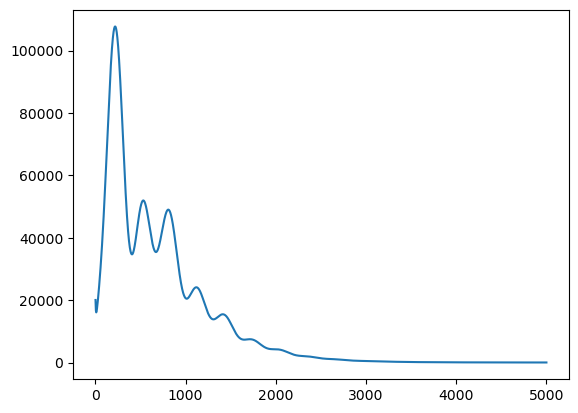

In [29]:
l = jnp.arange(2, 5000+1)
plt.plot(l, Capse_TT.get_Cl(input_test))

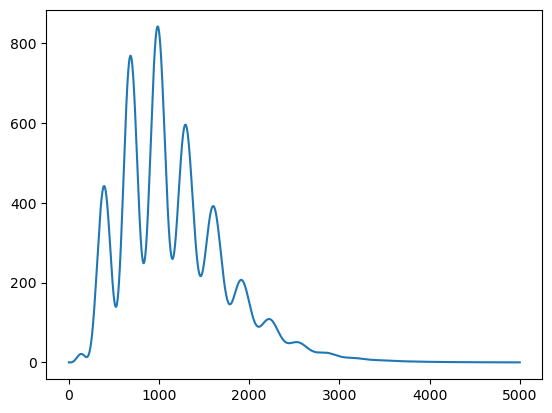

In [30]:
plt.plot(l, Capse_EE.get_Cl(input_test))

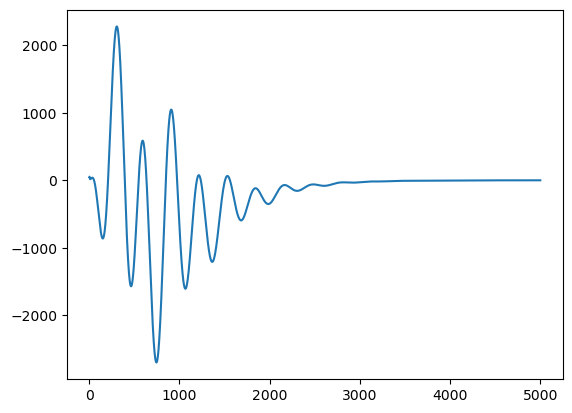

In [31]:
plt.plot(l, Capse_TE.get_Cl(input_test))

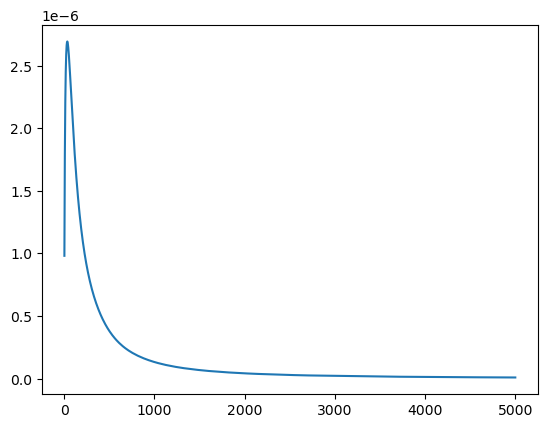

In [32]:
plt.plot(l, Capse_PP.get_Cl(input_test))